# Fine-tune pre-trained model with custom data

In [1]:
from fastai_old.text import *
import html
import spacy 

spacy.load('en_core_web_sm')

We're going to grab our custom style text data, e.g. the text of Alice in Wonderland, from the directory `data_style/`. This data tends to be small, so it's included in the repository. We will also create a directory in which we'll store our trained language models, `data_inf/custom_lm/`. This isn't included in the repository because it can be very large.

When we create the language model, we give it a path (in this case `data_inf/custom_lm/`). Then when we save the language model, it saves the data in `path/models/`. 

Note that we'll need to load two files to load the pre-trained data model. These should be located in `data_inf/pretrained/`. The files are `fwd_wt103.h5` and `itos_wt103.pkl`.

Finally, we'll set up a master name for this fine-tuning. The vocab and model will be saved with this name. The default here is `alice`.

In [2]:
import pandas as pd
df = pd.read_csv("data_style/popular_quotes_clean.csv")
text = df["text"].astype(str).tolist()

In [3]:
df["likes"].astype(int).min()

2228

In [4]:
likes = df["likes"].astype(int)
likes /= 1000
likes = [int(like) for like in likes]
max(likes)

191

In [6]:
text_likes = []
for line, likes in zip(text, likes):
    for i in range(likes):
        text_likes.append(line)
text_likes[:10]

['1 be impeccable with your wor',
 '1 be impeccable with your wor',
 'a bit of trash now and then is good for the severest reader it provides the necessary roughage in the literary diet',
 'a bit of trash now and then is good for the severest reader it provides the necessary roughage in the literary diet',
 'a book is really like a lover it arranges itself in your life in a way that is beautiful',
 'a book is really like a lover it arranges itself in your life in a way that is beautiful',
 'a book is really like a lover it arranges itself in your life in a way that is beautiful',
 'a book lying idle on a shelf is wasted ammunition',
 'a book lying idle on a shelf is wasted ammunition',
 'a book lying idle on a shelf is wasted ammunition']

In [10]:
from random import shuffle
shuffle(text_likes)

In [13]:
f = open("data_style/pop_quotes_likes.txt", "w")
for line in text_likes:
        f.write("<bos> " + line + " <eos>\n")
f.close()

In [8]:
f = open("data_style/pop_quotes.txt", "r")
f.read()
f.close()

In [14]:
DATA_PATH=Path('data_style/')
DATA_PATH.mkdir(exist_ok=True)

LM_PATH = Path('data_inf/custom_lm/')
LM_PATH.mkdir(exist_ok=True)

PRE_PATH=Path('data_inf/pretrained/')
PRE_PATH.mkdir(exist_ok=True)

NAME = 'pop_quotes'
ID = 'notebook'

Now we're going to load data that is a single text file of plain text. We'll need to split the text into chunks for efficient training and to hold out some data as validation. We'll set a minimum chunk size, and otherwise break at paragraphs.




In [15]:
minwords = 100

def get_texts(fname):
    texts = []
    with fname.open('r') as f:
        curr = ['', 0]
        for line in f:
            l = len(line.split(' '))
            if curr[1] + l > minwords:
                texts.append(curr[0])
                curr = [line, l]
            else:
                curr[0] += '\n' + line
                curr[1] += l
    if curr[0] != '':
        texts.append(curr[0])
    return np.array(texts)

data_file = NAME + '.txt'
all_texts = get_texts(DATA_PATH/data_file)
len(all_texts)

753

In [17]:
random.choice(all_texts)

'<bos> heres all you have to know about men and women women are crazy men are stupid and the main reason women are crazy is that men are stupid <eos>\n'

Now we'll split the data into training and validation data. 


In [18]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    all_texts, test_size=0.3)

# trn_texts = all_texts
# val_texts = all_texts

len(trn_texts), len(val_texts)

(527, 226)

Using the pandas DataFrame speeds up pre-processing, though it does feel a little like overkill.

In [19]:
col_names = ['text']
df_trn = pd.DataFrame({'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts}, columns=col_names)

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('.',' .').replace('?',' ?').replace('!',' !').replace('’'," '")
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
#     texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = df['text'].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer(lang='en_core_web_sm').proc_all_mp(partition_by_cores(texts))
    return tok

tok_trn = get_texts(df_trn)
tok_val = get_texts(df_val)

print(len(tok_trn), len(tok_val))

' '.join(tok_trn[0])

527 226


'<bos> i was wise enough never to grow up while fooling people into believing i had <eos> \n\n <bos> i was within and without simultaneously enchanted and repelled by the inexhaustible variety of life <eos> \n\n <bos> i was nt actually in love but i felt a sort of tender curiosity <eos> \n'

In [20]:
freq = Counter(p for o in tok_trn for p in o)

max_vocab = 60000
min_freq = 1

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

# itos = list(set(itos).union(itos2))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

itos_file = 'itos_' + NAME + ID + '.pkl'
with open(LM_PATH/itos_file, 'wb') as f:
    pickle.dump(itos, f)

vs=len(itos)
vs

2121

In [21]:
em_sz,nh,nl = 400,1150,3

PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):                     # for word in imbd vocab
    r = stoi2[w]                                # get the int in the pretrained vocab
    new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight
    
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

wd=1e-7
bptt=70
bs=16
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(LM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.model.load_state_dict(wgts)
PRE_LM_PATH

WindowsPath('data_inf/pretrained/fwd_wt103.h5')

Now we are in language modeling black magic land, following along with the fast.ai IMDB tutorial. They say to tune the last layer for one epoch first.

In [22]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

lr = 1e-3
lrs = lr

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

lm_name = NAME + ID + '_lm_last_ft'
learner.save(lm_name)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      5.592643   5.349327   0.145134  



And now we're going to fine-tune the whole model. First we're going to find a good learning rate, then unfreeze the whole thing (I think...) and fine-tune.



In [23]:
num_epochs = 30
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs)
lm_name = NAME + ID + '_lm_' + str(num_epochs) + 'epochs'
learner.save(lm_name)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.499588   4.065712   0.226007  



epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.953895   4.328289   0.208538  
    1      4.509111   3.966621   0.252857                                                                              
    2      4.158018   3.797353   0.26327                                                                               
    3      3.811106   3.732713   0.274749                                                                              
    4      3.476499   3.777167   0.282919                                                                              
    5      3.186155   3.838869   0.275505                                                                              
    6      2.885937   3.975965   0.268468                                                                              
    7      2.569664   4.121979   0.274019                                                                           

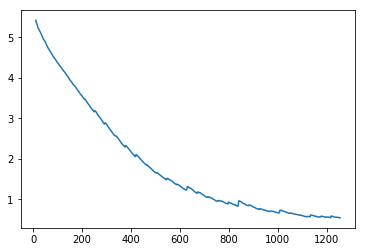

In [24]:
learner.sched.plot_loss()

In [25]:
lm_name

'pop_quotesnotebook_lm_30epochs'

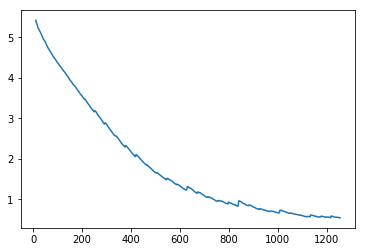

In [26]:
learner.sched.plot_loss()

In [26]:
num_epochs3 = 2
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs3)
lm_name = NAME + ID + '_lm_' + str(num_epochs + num_epochs3 + num_epochs3) + 'epochs'

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.464993   5.816205   0.242726  
    1      0.442881   5.839136   0.245298                                                                              


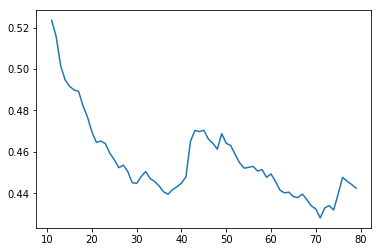

In [27]:
learner.sched.plot_loss()

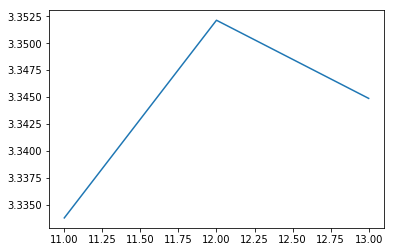

In [19]:
learner.save('alice1_lm_6epochs')
